<a href="https://colab.research.google.com/github/suinkangme/CalmMind_WAI_HACK_Canada/blob/main/Therapy_LLM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Therapy Summary LLM Based on Journal Prompt:



*   There is no good therapy informed journal summary dataset
*   We will train a LLM to create therapy context informed journal summaries for use in the therapy LLM by:

> *   Finetining an LLM on Mental Health WebMD Data and Counceling Conversations
> *   Use Knowledge Injection/ Prompt Engineering to create model specifically for journal prompt summarization and therapy journal prompts


*   Datasets:

> *   WebMD Mental Health QA
> *   Counceling Conversations

*   Models:

> *   Falcon 7B


*   Tutorials:

> *   Finetune: https://medium.com/@srishtinagu19/fine-tuning-falcon-7b-instruct-using-peft-lora-on-free-gpu-6fa1b0fcbcb

https://gathnex.medium.com/fine-tuning-llama-2-llm-on-google-colab-a-step-by-step-guide-dd79a788ac16

In [ ]:
!pip install -q -U git+https://github.com/huggingface/transformers.git
!pip install -q -U git+https://github.com/huggingface/peft.git
!pip install -q -U git+https://github.com/huggingface/accelerate.git
!pip install -q trl xformers wandb datasets einops gradio sentencepiece bitsandbytes

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [ ]:
from transformers import AutoModelForCausalLM, AutoTokenizer, BitsAndBytesConfig, HfArgumentParser, TrainingArguments, pipeline, logging, TextStreamer
from peft import LoraConfig, PeftModel, prepare_model_for_kbit_training, get_peft_model
import os,torch, wandb, platform, gradio, warnings
from datasets import load_dataset
from trl import SFTTrainer
from huggingface_hub import notebook_login


===================================BUG REPORT===================================
Welcome to bitsandbytes. For bug reports, please run

python -m bitsandbytes

 and submit this information together with your error trace to: https://github.com/TimDettmers/bitsandbytes/issues
bin /usr/local/lib/python3.10/dist-packages/bitsandbytes/libbitsandbytes_cuda118_nocublaslt.so
CUDA_SETUP: WARNING! libcudart.so not found in any environmental path. Searching in backup paths...
CUDA SETUP: CUDA runtime path found: /usr/local/cuda/lib64/libcudart.so
CUDA SETUP: Highest compute capability among GPUs detected: 7.0
CUDA SETUP: Detected CUDA version 118
CUDA SETUP: Loading binary /usr/local/lib/python3.10/dist-packages/bitsandbytes/libbitsandbytes_cuda118_nocublaslt.so...


/usr/local/lib/python3.10/dist-packages/bitsandbytes/cuda_setup/main.py:149: UserWarning: /usr/lib64-nvidia did not contain ['libcudart.so', 'libcudart.so.11.0', 'libcudart.so.12.0'] as expected! Searching further paths...
  warn(msg)
/usr/local/lib/python3.10/dist-packages/bitsandbytes/cuda_setup/main.py:149: UserWarning: WARNING: The following directories listed in your path were found to be non-existent: {PosixPath('/sys/fs/cgroup/memory.events /var/colab/cgroup/jupyter-children/memory.events')}
  warn(msg)
/usr/local/lib/python3.10/dist-packages/bitsandbytes/cuda_setup/main.py:149: UserWarning: WARNING: The following directories listed in your path were found to be non-existent: {PosixPath('//172.28.0.1'), PosixPath('http'), PosixPath('8013')}
  warn(msg)
/usr/local/lib/python3.10/dist-packages/bitsandbytes/cuda_setup/main.py:149: UserWarning: WARNING: The following directories listed in your path were found to be non-existent: {PosixPath('--logtostderr --listen_host=172.28.0.12 --

ImportError: ignored

In [ ]:
def print_system_specs():
    # Check if CUDA is available
    is_cuda_available = torch.cuda.is_available()
    print("CUDA Available:", is_cuda_available)
# Get the number of available CUDA devices
    num_cuda_devices = torch.cuda.device_count()
    print("Number of CUDA devices:", num_cuda_devices)
    if is_cuda_available:
        for i in range(num_cuda_devices):
            # Get CUDA device properties
            device = torch.device('cuda', i)
            print(f"--- CUDA Device {i} ---")
            print("Name:", torch.cuda.get_device_name(i))
            print("Compute Capability:", torch.cuda.get_device_capability(i))
            print("Total Memory:", torch.cuda.get_device_properties(i).total_memory, "bytes")
    # Get CPU information
    print("--- CPU Information ---")
    print("Processor:", platform.processor())
    print("System:", platform.system(), platform.release())
    print("Python Version:", platform.python_version())
print_system_specs()

CUDA Available: True
Number of CUDA devices: 1
--- CUDA Device 0 ---
Name: NVIDIA A100-SXM4-40GB
Compute Capability: (8, 0)
Total Memory: 42481549312 bytes
--- CPU Information ---
Processor: x86_64
System: Linux 5.15.120+
Python Version: 3.10.12


In [ ]:
# Pre trained model
model_name = "meta-llama/Llama-2-7b-hf"

# Dataset name
dataset_name = "Amod/mental_health_counseling_conversations"

# Hugging face repository link to save fine-tuned model(Create new repository in huggingface,copy and paste here)
new_model = "charisreneec/TherapyLLM-V2"

In [ ]:
notebook_login('huggingface token')

In [ ]:
# Load dataset (you can process it here)
dataset = load_dataset(dataset_name, split="train")
dataset["Context"][0]

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

"I'm going through some things with my feelings and myself. I barely sleep and I do nothing but think about how I'm worthless and how I shouldn't be here.\n   I've never tried or contemplated suicide. I've always wanted to fix my issues, but I never get around to it.\n   How can I change my feeling of being worthless to everyone?"

In [ ]:
# Load base model(llama-2-7b-hf) and tokenizer
bnb_config = BitsAndBytesConfig(
    load_in_4bit= True,
    bnb_4bit_quant_type= "nf4",
    bnb_4bit_compute_dtype= torch.float16,
    bnb_4bit_use_double_quant= False,
)
model = AutoModelForCausalLM.from_pretrained(
    model_name,
    quantization_config=bnb_config,
    device_map={"": 0}
)
model = prepare_model_for_kbit_training(model)
model.config.use_cache = False # silence the warnings. Please re-enable for inference!
model.config.pretraining_tp = 1
# Load LLaMA tokenizer
tokenizer = AutoTokenizer.from_pretrained(model_name, trust_remote_code=True)
tokenizer.pad_token = tokenizer.eos_token
tokenizer.add_eos_token = True
tokenizer.add_bos_token, tokenizer.add_eos_token

config.json:   0%|          | 0.00/609 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/26.8k [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/9.98G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/3.50G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/188 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/776 [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/500k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.84M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/414 [00:00<?, ?B/s]

(True, True)

In [ ]:
#monitering login
wandb.login(key="wandbkey")
run = wandb.init(project='Fine tuning llama-2-7B', job_type="training", anonymous="allow")

wandb: W&B API key is configured. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: charisrenee. Use `wandb login --relogin` to force relogin


In [ ]:
peft_config = LoraConfig(
    lora_alpha= 8,
    lora_dropout= 0.1,
    r= 16,
    bias="none",
    task_type="CAUSAL_LM",
    target_modules=["q_proj", "k_proj", "v_proj", "o_proj","gate_proj", "up_proj"]
)

In [ ]:
from datasets import Dataset

# Assuming `dataset` is your Dataset object
dataset = dataset.map(lambda example: {'text': '<human>:' + example['Context'] + '<therapyLLM>:' + example['Response']})

Map:   0%|          | 0/3512 [00:00<?, ? examples/s]

In [ ]:
dataset[0:100]

In [ ]:
dataset["text"][0]

"<human>:I'm going through some things with my feelings and myself. I barely sleep and I do nothing but think about how I'm worthless and how I shouldn't be here.\n   I've never tried or contemplated suicide. I've always wanted to fix my issues, but I never get around to it.\n   How can I change my feeling of being worthless to everyone?<therapyLLM>:If everyone thinks you're worthless, then maybe you need to find new people to hang out with.Seriously, the social context in which a person lives is a big influence in self-esteem.Otherwise, you can go round and round trying to understand why you're not worthless, then go back to the same crowd and be knocked down again.There are many inspirational messages you can find in social media. \xa0Maybe read some of the ones which state that no person is worthless, and that everyone has a good purpose to their life.Also, since our culture is so saturated with the belief that if someone doesn't feel good about themselves that this is somehow terri

In [ ]:
training_arguments = TrainingArguments(
    output_dir= "./results",
    num_train_epochs= 1,
    per_device_train_batch_size= 1,
    gradient_accumulation_steps= 2,
    optim = "paged_adamw_8bit",
    save_steps= 1000,
    logging_steps= 10,
    learning_rate= 2e-4,
    weight_decay= 0.001,
    fp16= False,
    bf16= False,
    max_grad_norm= 0.3,
    max_steps= -1,
    warmup_ratio= 0.3,
    group_by_length= True,
    lr_scheduler_type= "linear",
    report_to="wandb",
)

In [ ]:
# Setting sft parameters
trainer = SFTTrainer(
    model=model,
    train_dataset=dataset,
    peft_config=peft_config,
    max_seq_length= None,
    dataset_text_field="text",
    tokenizer=tokenizer,
    args=training_arguments,
    packing= False,
)

/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:194: UserWarning: You didn't pass a `max_seq_length` argument to the SFTTrainer, this will default to 1024
  warnings.warn(


Map:   0%|          | 0/3512 [00:00<?, ? examples/s]

In [ ]:
# Train model
trainer.train()

You're using a LlamaTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:429: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(


Step,Training Loss
10,2.203400
20,2.272400
30,2.503300
40,2.627200
50,2.775700
60,2.126100
70,2.302900
80,2.250700
90,2.145500
100,2.106100


/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:429: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(


TrainOutput(global_step=1756, training_loss=1.856941780359707, metrics={'train_runtime': 4006.1642, 'train_samples_per_second': 0.877, 'train_steps_per_second': 0.438, 'total_flos': 4.445513120865485e+16, 'train_loss': 1.856941780359707, 'epoch': 1.0})

In [ ]:
# Save the fine-tuned model
trainer.model.save_pretrained(new_model)
wandb.finish()
model.config.use_cache = True
model.eval()

In [ ]:
def stream(user_prompt):
    runtimeFlag = "cuda:0"
    system_prompt = 'You are a mental health chatbot and you will answer the question from the Human Input as a short and consize but accurate response. The Input is as follows:'
    B_INST, E_INST = "<Human>:\n", "<Response>:\n"

    prompt = f"{system_prompt}{B_INST}{user_prompt.strip()}\n\n{E_INST}"

    inputs = tokenizer([system_prompt], return_tensors="pt").to(runtimeFlag)

    streamer = TextStreamer(tokenizer, skip_prompt=True, skip_special_tokens=True)

    # Despite returning the usual output, the streamer will also print the generated text to stdout.
    _ = model.generate(**inputs, streamer=streamer, max_new_tokens=500)

#Music Recomender System

In [ ]:
#Valence Arousal Mapping

emotion_map = {'admiration' : {'VA':[0.3, -.1], "target": "joy"},
              'amusement'	: {'VA':[0.5,0.2], "target": "joy"},
              'anger'	: {'VA':[-0.5,0.8], "target": "relief"},
              'annoyance':	{'VA':[-.35,0.65], "target": "joy"},
              'approval':	{'VA':[.2,-0.22], "target": "joy"},
              'caring':	{'VA':[.3,0.2], "target": "joy"},
              'confusion':	{'VA':[-0.5,0.5], "target": "relief"},
              'curiosity':	{'VA':[.6,-.6], "target": "joy"},
              'desire':	{'VA':[0.2,0.8], "target": "relief"},
              'disappointment':	{'VA':[-.9,-.05], "target": "relief"},
              'disapproval':	{'VA':[-.3,.1], "target": "relief"},
              'disgust':	{'VA':[-0.7,0.5], "target": "relief"},
              'embarrassment':	{'VA':[-.4,-.6], "target": "joy"},
              'joy':	{'VA':[.9,.35], "target": "excitement"},
              'relief':	{'VA':[0.8,-.8], "target": "relief"},
              'sadness':	{'VA':[-.8,-.4], "target": "joy"},
              'excitement':	{'VA':[.5,.5], "target": "joy"},
              'fear':	{'VA':[-.2,.8], "target": "relief"},
              'gratitude':	{'VA':[.4,-.55], "target": "joy"},
              'grief':	{'VA':[-.7,-.55], "target": "joy"},
              'love':	{'VA':[.8,-.1], "target": "relief"},
              'nervousness':	{'VA':[-.7,.6], "target": "relief"},
              'optimism':	{'VA':[.3,-.3], "target": "relief"},
              'pride':	{'VA':[.4,-.7], "target": "relief"},
              'realization':	{'VA':[.2,.85], "target": "joy"},
              'remorse':	{'VA':[-.3,-.4], "target": "joy"},
              'surprise':	{'VA':[.3,.75], "target": "joy"},
              'neutral':	{'VA':[0,0], "target": "joy"}}


<ipython-input-85-4fb7beb6585f>:12: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


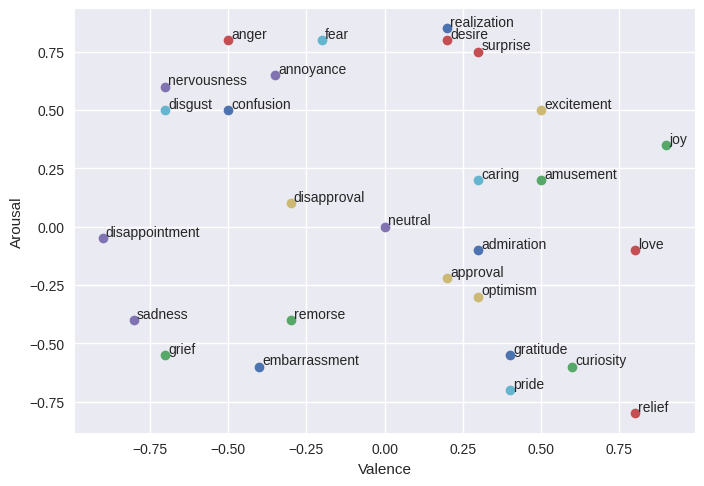

In [ ]:
import matplotlib.pyplot as plt
list_keys = list(emotion_map.keys())
for i in range(0,len(list_keys)):
  x = emotion_map[list_keys[i]]['VA'][0]
  y = emotion_map[list_keys[i]]['VA'][1]
  plt.plot(x,y, marker = 'o',label = list_keys[i])
  plt.annotate(list_keys[i], (x + 0.01, y+ 0.01))

plt.xlabel('Valence')
plt.ylabel('Arousal')
plt.grid(True, which='both')
plt.style.use('seaborn')
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = 'Ubuntu'
plt.rcParams['font.monospace'] = 'Ubuntu Mono'
plt.rcParams['font.size'] = 10
plt.rcParams['axes.labelsize'] = 10
plt.rcParams['axes.labelweight'] = 'bold'
plt.rcParams['xtick.labelsize'] = 8
plt.rcParams['ytick.labelsize'] = 8
plt.rcParams['legend.fontsize'] = 10
plt.rcParams['figure.titlesize'] = 12
plt.show()

In [ ]:
# excitement	0.983	0.603	0.340	0.435	0.445	103	0.5
# fear	0.992	0.758	0.603	0.671	0.672	78	0.5
# gratitude	0.990	0.960	0.881	0.919	0.914	352	0.5
# grief	0.999	0.000	0.000	0.000	0.000	6	0.5
# joy	0.978	0.647	0.559	0.600	0.590	161	0.5
# love	0.982	0.773	0.832	0.802	0.793	238	0.5
# nervousness	0.996	0.600	0.130	0.214	0.278	23	0.5
# optimism	0.972	0.667	0.376	0.481	0.488	186	0.5
# pride	0.997	0.000	0.000	0.000	0.000	16	0.5
# realization	0.974	0.541	0.138	0.220	0.264	145	0.5
# relief	0.998	0.000	0.000	0.000	0.000	11	0.5
# remorse	0.991	0.553	0.750	0.636	0.640	56	0.5
# sadness	0.977	0.621	0.494	0.550	0.542	156	0.5
# surprise	0.981	0.750	0.404	0.525	0.542	141	0.5
# neutral 0.981	0.750	0.404	0.525	0.542	141	0.5

In [ ]:
!pip install datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 521.2/521.2 kB 7.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 16.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 18.1 MB/s eta 0:00:00


In [ ]:
from datasets import load_dataset
#https://huggingface.co/datasets/maharshipandya/spotify-tracks-dataset
dataset = load_dataset("maharshipandya/spotify-tracks-dataset")

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

In [ ]:
dataset

DatasetDict({
    train: Dataset({
        features: ['Unnamed: 0', 'track_id', 'artists', 'album_name', 'track_name', 'popularity', 'duration_ms', 'explicit', 'danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo', 'time_signature', 'track_genre'],
        num_rows: 114000
    })
})

In [ ]:
dataset['train']['track_name'][1]

'Ghost - Acoustic'

In [ ]:
dataset['train']['popularity'][1]

55

In [ ]:
dataset['train']['artists'][1]

'Ben Woodward'

In [ ]:
#@title Filter Out white noise, sleep, and color noise
#List of Searchable Genres: https://everynoise.com/everynoise1d.cgi
print(len(dataset['train']))
dataset = dataset.filter(lambda example: example["track_genre"] != 'white noise')
print(len(dataset['train']))
dataset = dataset.filter(lambda example: example["track_genre"] != 'color noise')
print(len(dataset['train']))
dataset = dataset.filter(lambda example: example["track_genre"] != 'sleep')
print(len(dataset['train']))


114000


Filter:   0%|          | 0/114000 [00:00<?, ? examples/s]

114000


Filter:   0%|          | 0/114000 [00:00<?, ? examples/s]

114000


Filter:   0%|          | 0/114000 [00:00<?, ? examples/s]

113000


In [ ]:
#@title Compute Valence Arousal Scores (Z Score the Energy as this is not evenly distributed)
dataset = dataset.map(lambda example: {'mood_vec': [(example["valence" ]*2) -1, (((example["energy"]**2)*2) -1)]})

Map:   0%|          | 0/113000 [00:00<?, ? examples/s]

In [ ]:
dataset["train"]["mood_vec"][0]

[0.42999999999999994, -0.574958]

In [ ]:
print(dataset['train']['valence'][0])
print(dataset['train']['energy'][0])
print(dataset['train']['mood_vec'][0])

0.715
0.461
[0.715, 0.21252100000000002]


In [ ]:
dataset['train'][1]

{'Unnamed: 0': 1,
 'track_id': '4qPNDBW1i3p13qLCt0Ki3A',
 'artists': 'Ben Woodward',
 'album_name': 'Ghost (Acoustic)',
 'track_name': 'Ghost - Acoustic',
 'popularity': 55,
 'duration_ms': 149610,
 'explicit': False,
 'danceability': 0.42,
 'energy': 0.166,
 'key': 1,
 'loudness': -17.235,
 'mode': 1,
 'speechiness': 0.0763,
 'acousticness': 0.924,
 'instrumentalness': 5.56e-06,
 'liveness': 0.101,
 'valence': 0.267,
 'tempo': 77.489,
 'time_signature': 4,
 'track_genre': 'acoustic',
 'mood_vec': [0.267, 0.027556000000000004]}

In [ ]:
#@title Test The VA Calculations
input_emotion = 'confusion'
input_va = target_emotion = emotion_map[input_emotion]['VA']
print(input_va)
target_emotion = emotion_map[input_emotion]['target']
print(target_emotion)
target_va = emotion_map[target_emotion]['VA']
print(target_va)
import numpy as np
npts = 5
xcoords, ycoords = [input_va[0],target_va[0]], [input_va[1],target_va[1]]
xquery = np.linspace(xcoords[0],xcoords[1], npts)
yquery = np.linspace(ycoords[0],ycoords[1], npts)
print(xquery)
print(yquery)
dataset = dataset.map(lambda example: {'distances': np.linalg.norm([xquery[0],yquery[0]]-np.array(example['mood_vec']))})
dataset_sorted = dataset.sort('distances')
print(dataset['train']['distances'][0:20])
dataset_sorted['train']['distances'][0:20]

[-0.8, 0.25]
relief
[0.75, -0.75]
[-0.8    -0.4125 -0.025   0.3625  0.75  ]
[ 0.25  0.   -0.25 -0.5  -0.75]


Map:   0%|          | 0/114000 [00:00<?, ? examples/s]

[1.5296228293275438, 1.0703013594310717, 0.9264345632585175, 0.9620297084809804, 0.9860720054843866, 1.4840879354000558, 0.8825311609229445, 1.5243949619439183, 1.4781261786464646, 1.066742705623057, 1.1067836283574128, 0.9404945507550801, 1.4084548271066417, 1.0091268503017845, 1.2999496144081895, 1.0835889442034743, 1.2218183170995596, 1.4187331708252964, 1.4781261786464646, 1.1241814800111236]


[0.800040624031055,
 0.800235590373235,
 0.8004223884924759,
 0.8004223884924759,
 0.8005623023850175,
 0.8006975989029816,
 0.8013794357231786,
 0.8016339564289926,
 0.80189837267574,
 0.8020986987272826,
 0.8023322255150918,
 0.8023989032893801,
 0.8028007224710252,
 0.8032334654382872,
 0.8032334654382872,
 0.8037935058209914,
 0.8042014673575273,
 0.8042941004383908,
 0.806360341348705,
 0.8064762860741784]

In [ ]:
test = dataset['train'].train_test_split(test_size=0.01,shuffle = False)
test

DatasetDict({
    train: Dataset({
        features: ['Unnamed: 0', 'track_id', 'artists', 'album_name', 'track_name', 'popularity', 'duration_ms', 'explicit', 'danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo', 'time_signature', 'track_genre', 'mood_vec', 'distances'],
        num_rows: 112860
    })
    test: Dataset({
        features: ['Unnamed: 0', 'track_id', 'artists', 'album_name', 'track_name', 'popularity', 'duration_ms', 'explicit', 'danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo', 'time_signature', 'track_genre', 'mood_vec', 'distances'],
        num_rows: 1140
    })
})

In [ ]:
dataset = dataset.map(lambda example: {'distances': np.linalg.norm([-.8,-.4]-np.array(example['mood_vec']))})

Map:   0%|          | 0/113000 [00:00<?, ? examples/s]

In [ ]:
dataset_sorted = dataset.sort('distances')

In [ ]:
dataset_sorted["train"]["distances"][0]

0.0060307266560506835

In [ ]:
R =  0.1
r = R * np.sqrt(random.uniform(0, 1))
theta = random.uniform(0, 1) * 2 * np.pi
x = 0 + r * np.cos(theta)
y = 0+ r * np.sin(theta)
print(x)
print(y)

0.05287273909639853
-0.020572197127758755


In [ ]:
import random
import numpy as np

def recommend(input_emotion,dataset,emotion_map, npts = 3, n_recs = 10, R = .1):

    # # Crawl valence and arousal of given track from spotify api
    # track_features = sp.track_audio_features(track_id)
    # track_moodvec = np.array([track_features.valence, track_features.energy])

    # Get valence and arousal of input emotion and target emotion
    input_va = target_emotion = emotion_map[input_emotion]['VA']
    target_emotion = emotion_map[input_emotion]['target']
    target_va = emotion_map[target_emotion]['VA']
    # Create a list with the tragectory of the playlist as valence arousal pairs
    xcoords, ycoords = [input_va[0],target_va[0]], [input_va[1],target_va[1]]
    xquery = np.linspace(xcoords[0],xcoords[1], npts)
    yquery = np.linspace(ycoords[0],ycoords[1], npts)
    print(xquery)
    print(yquery)
    #Create Empty Playlist
    Playlist= []

    #For each element of tragectory
    for i in range(0,npts):
      print(i)
      grab_xy = [xquery[i],yquery[i]]
      r = R * np.sqrt(random.uniform(0, 1))
      theta = random.uniform(0, 1)* 2 * np.pi
      x = xquery[i] + r * np.cos(theta)
      y = yquery[i] + r * np.sin(theta)
      print(grab_xy)
      grab_xy = [x,y]
      print(grab_xy)
      # Compute distances to all reference tracks
      dataset = dataset.map(lambda example: {'distances': np.linalg.norm(grab_xy-np.array(example['mood_vec']))})
      dataset_sorted = dataset.sort('distances')
      # #ref_df["distances"] = ref_df["mood_vec"].apply(lambda x: norm(track_moodvec-np.array(x)))
      # # Sort distances from lowest to highest
      # ref_df_sorted = ref_df.sort_values(by = "distances", ascending = True)
      # # If the input track is in the reference set, it will have a distance of 0, but should not be recommendet
      # ref_df_sorted = ref_df_sorted[ref_df_sorted["id"] != track_id]

      # Sort top 1% of distance ranked by popularity
      dataset_popular = dataset_sorted['train'].select(range(n_recs))
      print(dataset_popular[0])
      #dataset_popular = dataset_sorted['train'].train_test_split(test_size=0.0001,shuffle = False)
      dataset_popular_sorted = dataset_popular.sort('popularity')
      print(len(dataset_popular_sorted ))
      song_added = 0
      print(len(Playlist))
      if len(Playlist) == 0:
        Playlist.append(dataset_popular_sorted[0])
      else:
        for i in range(0,n_recs):
            for j in range(0,len(Playlist)):
              if song_added == 0:
                # print(dataset_popular_sorted['track_id'][i])
                # print(Playlist[0]['track_id'])
                if dataset_popular_sorted['track_id'][i] != Playlist[0]['track_id']:
                  Playlist.append(dataset_popular_sorted[0])
                  song_added = 1
      del dataset_sorted, dataset_popular, dataset_popular_sorted
      dataset.remove_columns('distances')


    # Return n recommendations
    return Playlist

In [ ]:
emotion = "sadness"
Playlist = recommend(input_emotion = emotion, dataset = dataset,emotion_map = emotion_map, npts = 5, n_recs = 5, R = 0.1)

[-0.8   -0.375  0.05   0.475  0.9  ]
[-0.4    -0.2125 -0.025   0.1625  0.35  ]
0
[-0.8, -0.4]
[-0.8161013080423435, -0.3246055613403356]


Map:   0%|          | 0/113000 [00:00<?, ? examples/s]

{'Unnamed: 0': 73883, 'track_id': '2nQGEVtP6hTGiddjZm7iVF', 'artists': 'John Talabot', 'album_name': 'My Old School', 'track_name': 'Afrika', 'popularity': 19, 'duration_ms': 454986, 'explicit': False, 'danceability': 0.732, 'energy': 0.583, 'key': 7, 'loudness': -9.21, 'mode': 0, 'speechiness': 0.0596, 'acousticness': 0.0147, 'instrumentalness': 0.958, 'liveness': 0.0967, 'valence': 0.0895, 'tempo': 113.997, 'time_signature': 4, 'track_genre': 'minimal-techno', 'mood_vec': [-0.821, -0.3202220000000001], 'distances': 0.006573643808459032}
5
0
1
[-0.375, -0.21250000000000002]
[-0.38494629711679873, -0.1731825148062584]


Map:   0%|          | 0/113000 [00:00<?, ? examples/s]

{'Unnamed: 0': 75163, 'track_id': '5aLmNHoANEqTeW05QIzaZp', 'artists': 'Enigma', 'album_name': 'Seven Lives Many Faces', 'track_name': 'La Puerta Del Cielo', 'popularity': 45, 'duration_ms': 208266, 'explicit': False, 'danceability': 0.521, 'energy': 0.643, 'key': 7, 'loudness': -8.212, 'mode': 1, 'speechiness': 0.0364, 'acousticness': 0.0393, 'instrumentalness': 0.00166, 'liveness': 0.605, 'valence': 0.308, 'tempo': 94.326, 'time_signature': 4, 'track_genre': 'new-age', 'mood_vec': [-0.384, -0.17310199999999998], 'distances': 0.0009497162035515695}
5
1
2
[0.050000000000000044, -0.025000000000000022]
[0.055404947429387716, -0.013210187050607837]


Map:   0%|          | 0/113000 [00:00<?, ? examples/s]

{'Unnamed: 0': 89909, 'track_id': '5e50NiIlOc2YJIftHzoehd', 'artists': 'Becky G', 'album_name': 'MALA SANTA', 'track_name': 'MALA SANTA', 'popularity': 65, 'duration_ms': 173826, 'explicit': False, 'danceability': 0.851, 'energy': 0.701, 'key': 9, 'loudness': -3.649, 'mode': 1, 'speechiness': 0.0396, 'acousticness': 0.311, 'instrumentalness': 0.000211, 'liveness': 0.163, 'valence': 0.527, 'tempo': 98.039, 'time_signature': 4, 'track_genre': 'reggaeton', 'mood_vec': [0.05400000000000005, -0.017198000000000158], 'distances': 0.0042280644979333145}
5
2
3
[0.4750000000000001, 0.16249999999999998]
[0.48127446212535535, 0.21853599712182403]


Map:   0%|          | 0/113000 [00:00<?, ? examples/s]

{'Unnamed: 0': 17055, 'track_id': '5vJ8wLhKQUsIAmm9kz0PRL', 'artists': 'DJ Envy;Fetty Wap;DJ Sliink', 'album_name': 'Text Ur Number (feat. DJ Sliink & Fetty Wap)', 'track_name': 'Text Ur Number (feat. DJ Sliink & Fetty Wap)', 'popularity': 19, 'duration_ms': 242134, 'explicit': False, 'danceability': 0.691, 'energy': 0.782, 'key': 8, 'loudness': -5.365, 'mode': 1, 'speechiness': 0.0561, 'acousticness': 0.0211, 'instrumentalness': 1.88e-05, 'liveness': 0.406, 'valence': 0.741, 'tempo': 139.946, 'time_signature': 4, 'track_genre': 'club', 'mood_vec': [0.482, 0.22304800000000014], 'distances': 0.004569964461591937}
5
3
4
[0.9, 0.35]
[0.8984081682962901, 0.38690164706488694]


Map:   0%|          | 0/113000 [00:00<?, ? examples/s]

{'Unnamed: 0': 95635, 'track_id': '3s5cJHIsm91npF99cASuZs', 'artists': 'Frankie Ruiz', 'album_name': 'En Vivo...Y a Todo Color...!', 'track_name': 'Me Acostumbré', 'popularity': 28, 'duration_ms': 289960, 'explicit': False, 'danceability': 0.695, 'energy': 0.832, 'key': 10, 'loudness': -4.998, 'mode': 0, 'speechiness': 0.0388, 'acousticness': 0.24, 'instrumentalness': 0.0, 'liveness': 0.0524, 'valence': 0.949, 'tempo': 100.777, 'time_signature': 4, 'track_genre': 'salsa', 'mood_vec': [0.8979999999999999, 0.3844479999999999], 'distances': 0.0024873651274240475}
5
4


In [ ]:
#Print Playlist Tracks
Playlist

[{'Unnamed: 0': 73883,
  'track_id': '2nQGEVtP6hTGiddjZm7iVF',
  'artists': 'John Talabot',
  'album_name': 'My Old School',
  'track_name': 'Afrika',
  'popularity': 19,
  'duration_ms': 454986,
  'explicit': False,
  'danceability': 0.732,
  'energy': 0.583,
  'key': 7,
  'loudness': -9.21,
  'mode': 0,
  'speechiness': 0.0596,
  'acousticness': 0.0147,
  'instrumentalness': 0.958,
  'liveness': 0.0967,
  'valence': 0.0895,
  'tempo': 113.997,
  'time_signature': 4,
  'track_genre': 'minimal-techno',
  'mood_vec': [-0.821, -0.3202220000000001],
  'distances': 0.006573643808459032},
 {'Unnamed: 0': 66339,
  'track_id': '5U3GLcPtqs5olKorFJmB6H',
  'artists': 'Mark D. Pencil',
  'album_name': 'The Exercise Game',
  'track_name': 'The Exercise Game # 1',
  'popularity': 14,
  'duration_ms': 344640,
  'explicit': False,
  'danceability': 0.626,
  'energy': 0.644,
  'key': 1,
  'loudness': -8.961,
  'mode': 1,
  'speechiness': 0.211,
  'acousticness': 0.0236,
  'instrumentalness': 0.19,
  

In [ ]:
#Print Playlist Tracks
Playlist #Joy

[{'Unnamed: 0': 1656,
  'track_id': '2BPrkxZ7JBCwTzyGyJyNaQ',
  'artists': 'La BOA',
  'album_name': 'La Bestia',
  'track_name': 'Vuelo Antillano',
  'popularity': 18,
  'duration_ms': 266986,
  'explicit': False,
  'danceability': 0.771,
  'energy': 0.735,
  'key': 9,
  'loudness': -7.033,
  'mode': 1,
  'speechiness': 0.0376,
  'acousticness': 0.0142,
  'instrumentalness': 0.763,
  'liveness': 0.319,
  'valence': 0.95,
  'tempo': 107.975,
  'time_signature': 4,
  'track_genre': 'afrobeat',
  'mood_vec': [0.8999999999999999, 0.08044999999999991],
  'distances': 0.0045363145716453696},
 {'Unnamed: 0': 25191,
  'track_id': '26bdkzE7QpGy8qE6nveFUq',
  'artists': 'Quincy Jones;Charles May',
  'album_name': 'Disco Boogie Mood',
  'track_name': 'Ai No Corrida',
  'popularity': 1,
  'duration_ms': 386600,
  'explicit': False,
  'danceability': 0.797,
  'energy': 0.765,
  'key': 4,
  'loudness': -11.377,
  'mode': 0,
  'speechiness': 0.0397,
  'acousticness': 0.0695,
  'instrumentalness': 0.

<ipython-input-86-1fc52fd412de>:21: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


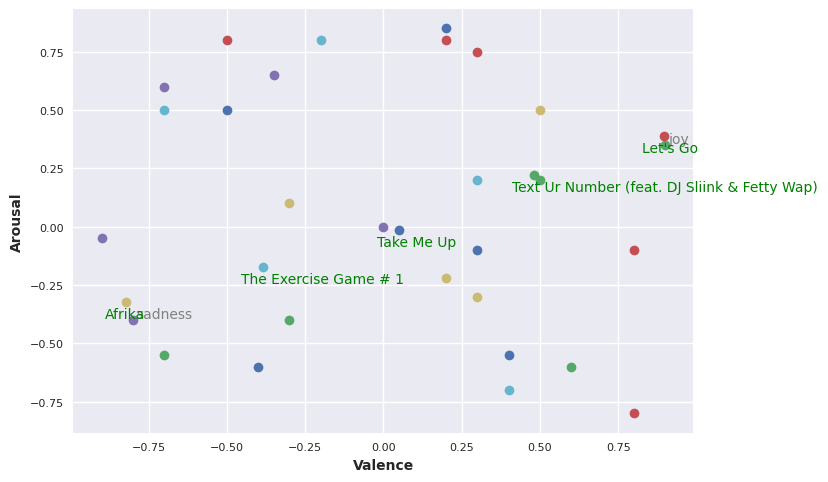

In [ ]:
#Plot Valence Arousal Map
import matplotlib.pyplot as plt
list_keys = list(emotion_map.keys())
for i in range(0,len(list_keys)):
  x = emotion_map[list_keys[i]]['VA'][0]
  y = emotion_map[list_keys[i]]['VA'][1]
  plt.plot(x,y, marker = 'o',label = list_keys[i])
  if list_keys[i] in [emotion, emotion_map[emotion]['target']]:
    plt.annotate(list_keys[i], (x + 0.01, y+ 0.01), color = 'grey')

for i in range(0, len(Playlist)):
  x = (Playlist[i]['valence']  *2) -1
  y = ((Playlist[i]['energy']**2)*2)-1
  plt.plot(x,y, marker = 'o',label = Playlist[i]['track_name'] )
  plt.annotate(Playlist[i]['track_name'] , (x - 0.07, y- 0.07), color = 'green')


plt.xlabel('Valence')
plt.ylabel('Arousal')
plt.grid(True, which='both')
plt.style.use('seaborn')
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = 'Ubuntu'
plt.rcParams['font.monospace'] = 'Ubuntu Mono'
plt.rcParams['font.size'] = 10
plt.rcParams['axes.labelsize'] = 10
plt.rcParams['axes.labelweight'] = 'bold'
plt.rcParams['xtick.labelsize'] = 8
plt.rcParams['ytick.labelsize'] = 8
plt.rcParams['legend.fontsize'] = 10
plt.rcParams['figure.titlesize'] = 12
plt.show()

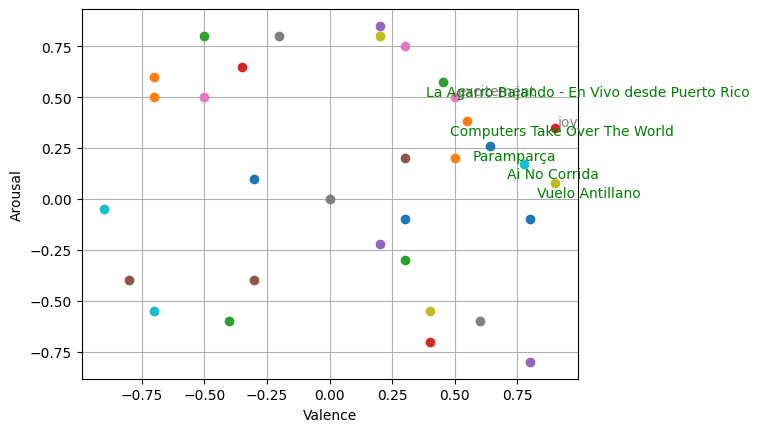

In [ ]:
#Plot Valence Arousal Map
import matplotlib.pyplot as plt
list_keys = list(emotion_map.keys())
for i in range(0,len(list_keys)):
  x = emotion_map[list_keys[i]]['VA'][0]
  y = emotion_map[list_keys[i]]['VA'][1]
  plt.plot(x,y, marker = 'o',label = list_keys[i])
  if list_keys[i] in [emotion, emotion_map[emotion]['target']]:
    plt.annotate(list_keys[i], (x + 0.01, y+ 0.01), color = 'grey')

for i in range(0, len(Playlist)):
  x = (Playlist[i]['valence']  *2) -1
  y = ((Playlist[i]['energy']**2)*2)-1
  plt.plot(x,y, marker = 'o',label = Playlist[i]['track_name'] )
  plt.annotate(Playlist[i]['track_name'] , (x - 0.07, y- 0.07), color = 'green')


plt.xlabel('Valence')
plt.ylabel('Arousal')
plt.grid(True, which='both')
plt.show()

In [ ]:
#Create List of Uris
uris = []
for i in range(0,len(Playlist)):
  uris.append(Playlist[i]['track_id'])

print(uris)

['3j3dGyA2pCK6OuwoVbtb9f', '2w8OZpyOHhT0ykCqLfejQB', '6DPl2JQGyXlACUgi90WHfV', '2s6wSsFT1xOpd6EQT1Cu80', '7f5sYbjqdVoBYl2KsF9Z27']


In [ ]:
#Automatically Create Spotify Playlist and Return Playlist ID
import json
import requests

user_id = "Your ID"
token = "YOUR_TOKEN_HERE"
endpoint_url = f"https://api.spotify.com/v1/users/{user_id}/playlists"
request_body = json.dumps({
          "name": "Indie bands like Franz Ferdinand but using Python",
          "description": "My first programmatic playlist, yooo!",
          "public": False # let's keep it between us - for now
        })
response = requests.post(url = endpoint_url, data = request_body, headers={"Content-Type":"application/json",
                        "Authorization":"Bearer "+ token})

playlist_id = response.json()['id']
endpoint_url = f"https://api.spotify.com/v1/playlists/{playlist_id}/tracks"

request_body = json.dumps({
          "uris" : uris
        })
response = requests.post(url = endpoint_url, data = request_body, headers={"Content-Type":"application/json",
                        "Authorization":"Bearer " + token})

print(response.status_code)

print(playlist_id)

# Ensemble Model for CalmMind

In [ ]:
#Pip Installs
!pip install -Uqqq pip
!pip install -qqq bitsandbytes==0.39.0
!pip install -qqq torch==2.0.1
#!pip install -qqq -U git+https://github.com/huggingface/transformers.git@e03a9cc
#!pip install -qqq -U git+https://github.com/huggingface/peft.git@42a184f
#!pip install -qqq -U git+https://github.com/huggingface/accelerate.git@c9fbb71
!pip install transformers
!pip install peft
!pip install accelerate
!pip install -qqq datasets==2.12.0
!pip install -qqq loralib==0.1.1
!pip install -qqq einops==0.6.1

!pip install -q trl xformers wandb datasets einops gradio sentencepiece bitsandbytes

#Imports
import sys
from transformers import pipeline
from transformers import LlamaForCausalLM, LlamaTokenizer, RobertaForSequenceClassification, RobertaTokenizer
#CalmMind Function
def CalmMind(text, stress, emotion_map):
  #Set up Models
    emotion_classifier = pipeline(task="text-classification", model="SamLowe/roberta-base-go_emotions")
    risk_tokenizer = RobertaTokenizer.from_pretrained("vibhorag101/roberta-base-suicide-prediction-phr")
    risk_classifier = RobertaForSequenceClassification.from_pretrained("vibhorag101/roberta-base-suicide-prediction-phr")
    #stress_classifier =
    #summary_llm = Model Was Way too Large (27G and Kept causing issues)
    therapyllm_tokenizer = LlamaTokenizer.from_pretrained("caffeinatedwoof/llama-2-7b-chat-hf-amod-mental-health-counseling-conversations")
    therapyllm_model = LlamaForCausalLM.from_pretrained("caffeinatedwoof/llama-2-7b-chat-hf-amod-mental-health-counseling-conversations")
  #Emotion Detection from Text
    detected_emotion = emotion_classifier(text)
    top_two_emotions = detected_emotion[:2]['label']
    output_str = ", ".join([f"{emotion['label']}: {emotion['score'] * 100:.2f}%" for emotion in model_output])
  #Risk Assesment From Text
    inputs = tokenizer(text, return_tensors="pt")
    outputs = model(**inputs)
    logits = outputs.logits
    predicted_class = logits.argmax(dim=1).item()
    class_labels = {0: 'High suicide risk', 1: 'no-risk'}
    risk_assesment = class_labels[predicted_class]
  #Stress Assesment from BioSensor (Dummy Data) (Also Still working on finding a good dataset to train with...)
    #Low = High Stress Management Score
    if stress in range(0,90):
      stress_score = 'low'
    #Med = Med Stress Management Score
    elif stress in range(90,140):
      stress_score = 'medium'
    #High = Low Stress Management Score
    elif stress in range(140,1000):
      stress_Score = 'high'

  #Simple Music Reccomender (Currently Returns Same Song - Will be fixed)
    Playlist = recommend(input_emotion = detected_emotion, dataset = dataset,emotion_map = emotion_map, npts = 5, n_recs = 5, R = 0.1)
    Playlist_uri = generate_playlist()
  #Therapy LLM Journal Prompts
    Instructions = "Instructions: You are a responsive AI powered journal called JournalLLM. Below is a journal entry from a user describing their life circumstances and any difficulties. You should provide three journal prompt questions that could help them understand these feelings and increase their emotional granulatiry, overall contenement and general affect and mental health. Please be sensitive and empathetic, and please do not directly diagnose them with any issuse but rather encourage self reflection."
    prompt = Instructions + "The users detected emotional state is " + detected_emotion[0]['label'] + ' and ' + detected_emotion[0]['label'] + ' and their physical stress level detected is ' + stress_score + '. Journal Prompt: ' + text + ' TherapyLLM:'
    model_inputs = tokenizer(prompt, return_tensors="pt")
    journal_prompts = model.generate(**model_inputs)
    return detected_emotion, risk_assesment, stress_score, journal_prompts, Playlist_uri
    #detected_emotion = string
    #risk_assesment = string
    #stress_mangement_score = string
    #journal_prompts = string
    #music_reccomendation = string

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 14.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 101.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 47.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 123.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 2.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 19.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 38.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.2/124.2 MB 7.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.0/196.0 MB 5.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 209.8/209.8 MB 5.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.1/99.1 kB 8.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.3/49.3 kB 3.

In [ ]:
#Pip Installs
!pip install -Uqqq pip
!pip install -qqq bitsandbytes==0.39.0
!pip install -qqq torch==2.0.1
#!pip install -qqq -U git+https://github.com/huggingface/transformers.git@e03a9cc
#!pip install -qqq -U git+https://github.com/huggingface/peft.git@42a184f
#!pip install -qqq -U git+https://github.com/huggingface/accelerate.git@c9fbb71
!pip install transformers
!pip install peft
!pip install accelerate
!pip install -qqq datasets==2.12.0
!pip install -qqq loralib==0.1.1
!pip install -qqq einops==0.6.1
!pip install -q trl xformers wandb datasets einops gradio sentencepiece bitsandbytes


#Imports
import sys
from transformers import pipeline
from transformers import LlamaForCausalLM, LlamaTokenizer, RobertaForSequenceClassification, RobertaTokenizer


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 22.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.2/92.2 MB 15.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 619.9/619.9 MB 2.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.0/21.0 MB 111.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 849.3/849.3 kB 54.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.8/11.8 MB 135.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 557.1/557.1 MB 2.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.1/317.1 MB 3.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 168.4/168.4 MB 13.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.6/54.6 MB 43.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 102.6/102.6 MB 21.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 173.2/173.2 MB 6.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━

In [ ]:
#Set up Models
emotion_classifier = pipeline(task="text-classification", model="SamLowe/roberta-base-go_emotions")
risk_tokenizer = RobertaTokenizer.from_pretrained("vibhorag101/roberta-base-suicide-prediction-phr")
risk_classifier = RobertaForSequenceClassification.from_pretrained("vibhorag101/roberta-base-suicide-prediction-phr")
#stress_classifier =
#summary_llm = Model Was Way too Large (27G and Kept causing issues)
therapyllm_tokenizer = LlamaTokenizer.from_pretrained("caffeinatedwoof/llama-2-7b-chat-hf-amod-mental-health-counseling-conversations")
therapyllm_model = LlamaForCausalLM.from_pretrained("caffeinatedwoof/llama-2-7b-chat-hf-amod-mental-health-counseling-conversations")


In [ ]:
text = """
Today was one of those days where the weight of everything felt insurmountable. The simplest tasks morphed into mountains, and the thought of going out with friends seemed like an impossible journey. Depression wrapped its heavy cloak around me, making it hard to see beyond the shadows.

The to-do list sat untouched, a constant reminder of unmet expectations. Each unchecked item echoed a silent disappointment. It's frustrating to want to do so much, yet find myself paralyzed by a fog of despair.

The invitation from friends hung in the air, a tempting offer to break free from the isolation. However, the energy required to socialize felt like an expenditure I couldn't afford. Guilt intertwined with the sadness, creating a complex tapestry of emotions.

As I write this, there's a longing for a better day, a day when the clouds might lift even just a little. For now, I'll sit with the heaviness, acknowledging it as part of the struggle. Tomorrow is a new opportunity, a chance for a different narrative.

"""

In [ ]:
#Emotion Detection from Text
detected_emotion = emotion_classifier(text)
top_two_emotions = detected_emotion[:2]['label']
output_str = ", ".join([f"{emotion['label']}: {emotion['score'] * 100:.2f}%" for emotion in model_output])
#Risk Assesment From Text
inputs = tokenizer(text, return_tensors="pt")
outputs = model(**inputs)
logits = outputs.logits
predicted_class = logits.argmax(dim=1).item()
class_labels = {0: 'High suicide risk', 1: 'no-risk'}
risk_assesment = class_labels[predicted_class]
#Stress Assesment from BioSensor (Dummy Data) (Also Still working on finding a good dataset to train with...)
#Low = High Stress Management Score
if stress in range(0,90):
  stress_score = 'low'
#Med = Med Stress Management Score
elif stress in range(90,140):
  stress_score = 'medium'
#High = Low Stress Management Score
elif stress in range(140,1000):
  stress_Score = 'high'
#LLM Journal Summary

#Simple Music Reccomender (Currently Returns Same Song - Will be fixed)
music_reccomendation = 'Never Gonna Give You Up by Rick Astley'
#Therapy LLM Journal Prompts
Instructions = "Instructions: You are a responsive AI powered journal called JournalLLM. Below is a journal entry from a user describing their life circumstances and any difficulties. You should provide three journal prompt questions that could help them understand these feelings and increase their emotional granulatiry, overall contenement and general affect and mental health. Please be sensitive and empathetic, and please do not directly diagnose them with any issuse but rather encourage self reflection."
prompt = Instructions + "The users detected emotional state is " + detected_emotion[0]['label'] + ' and ' + detected_emotion[0]['label'] + ' and their physical stress level detected is ' + stress_score + '. Journal Prompt: ' + text + ' TherapyLLM:'
model_inputs = tokenizer(prompt, return_tensors="pt")
journal_prompts = model.generate(**model_inputs)